In [3]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)
import pandas as pd
import numpy as np
df=pd.read_csv('sample.csv')

from sklearn.metrics import accuracy_score,balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
def make_classification_score(y_test, predictions, modelName): 
    prec=precision_score(y_test, predictions,average='macro') 
    rec=recall_score(y_test, predictions,average='macro') 
    f1=f1_score(y_test, predictions,average='macro') 
    acc=accuracy_score(y_test, predictions) 
    bal_acc=balanced_accuracy_score(y_test, predictions) 
    score = {'Model': [modelName], 'Accuracy': [acc],'Balanced_Accuracy':[bal_acc], 'f1': [f1], 'Recall': [rec], 'Precision': [prec], 'y_test size': [len(y_test)]} 
    df_score = pd.DataFrame(data=score) 
    return df_score

def ROC_curve(modelName,X_test,y_test):
    probability = modelName.predict_proba(X_test) 
    model_fpr, model_tpr, _ = roc_curve(y_test, probability[:, 1]) 
    plt.plot(model_fpr, model_tpr, marker='.', label='Logit') 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate (recall)') 
    plt.legend() 
    plt.title("ROC Curve") 
    plt.show() 

def PRC_curve(modelName,X_test,y_test): 
    probability = modelName.predict_proba(X_test) 
    precision, recall, thresholds = precision_recall_curve(y_test, probability[:, 1]) 
    fscore = (2 * precision * recall) / (precision + recall)
    
    plt.scatter(recall[ix], precision[ix], s= 100, marker='*', color='black', label='Best')
    plt.plot(recall, precision, marker='.', label='Logit')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()
    
#subset df by removing small sites
from sklearn.preprocessing import MinMaxScaler
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

df_nosmallsites=df.loc[df.sites.isin(['a','b','c','d']),:]
#df_nosmallsites=df_nosmallsites.sample(n=1000,random_state=23)
X = df_nosmallsites.drop(['sites','Unnamed: 0'],axis = 1)
y = df_nosmallsites.sites
X = X.loc[:,X.std()>=X.std().quantile(q=0.75)]

def train_test_split_ (X,y):
    x_train, x_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size=0.2, 
                                                        random_state=42)
    
    return x_train, x_test, y_train, y_test
def normalization_ (x_train,x_test):
    scaler = StandardScaler()
    normalized_x_train = pd.DataFrame(
        scaler.fit_transform(x_train),
        columns = x_train.columns
    )
    normalized_x_test = pd.DataFrame(
        scaler.transform(x_test),
        columns = x_test.columns
    )
    return normalized_x_train, normalized_x_test

x_train, x_test, y_train, y_test = train_test_split_(X,y)
normalized_x_train, normalized_x_test=normalization_(x_train,x_test)

def model_fitting_plotting (model,normalized_x_train,y_train,normalized_x_test,y_test):
    model.fit(normalized_x_train, y_train)

    y_train_pred = model.predict(normalized_x_train)
    y_pred = model.predict(normalized_x_test)

    df_train_result = make_classification_score(y_train,y_train_pred,'multinomial_logistic_regression_train')
    df_test_result = make_classification_score(y_test,y_pred,'multinomial_logistic_regression_test')

    display(df_train_result)
    display(df_test_result)

    conf_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,6))
    disp=ConfusionMatrixDisplay(conf_mat,display_labels=model.classes_)
    disp.plot()
    plt.title('logistic regression balanced accuracy: {}'.format(balanced_accuracy_score(y_test, y_pred)))
    plt.xticks(rotation=90)

from sanbomics.tools import id_map
mapper = id_map(species = 'human')

def feature_importance_plot (model, legend, num_gene_show=10):
    feature_order=np.argsort(np.amax(abs(model.coef_),axis=0))
    feature_importance=np.sort(np.amax(abs(model.coef_),axis=0))
    feature_rank = pd.DataFrame(data=feature_importance[-10:], index=normalized_x_train.columns[feature_order[-10:]].map(mapper.mapper), columns=[legend]).sort_values(by = legend, ascending=False)
    plt.figure(figsize=(6,10))
    feature_rank.nlargest(10, columns="coefficient").plot(kind='barh') ## plot top 10 features
    plt.title('feature importance by '+ legend + ' for logistic regression')
    plt.show()

/home2/posit/python/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home2/posit/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/posit/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Accuracy,Balanced_Accuracy,f1,Recall,Precision,y_test size
0,multinomial_logistic_regression_train,0.497574,0.660253,0.479478,0.660253,0.417952,3091


,Model,Accuracy,Balanced_Accuracy,f1,Recall,Precision,y_test size
0,multinomial_logistic_regression_test,0.514877,0.675413,0.486864,0.675413,0.423505,773


<Figure size 600x600 with 0 Axes>

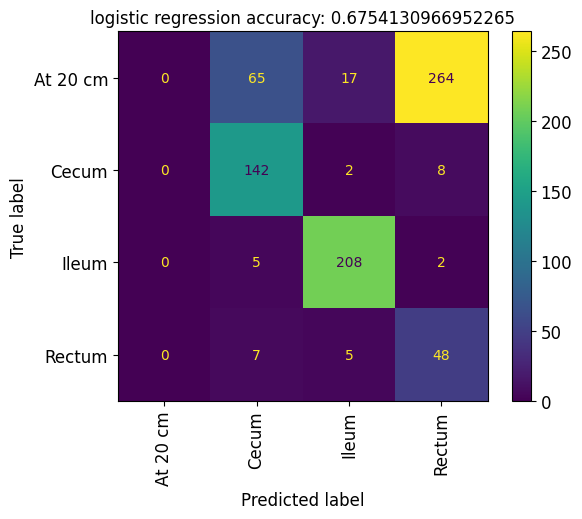

In [11]:
#l1 with reduced feature with normalization
multi_logreg = LogisticRegression(multi_class='multinomial',solver='saga',
                                max_iter=1000,class_weight='balanced',penalty='l1', warm_start=True,C=0.001)


model_fitting_plotting (multi_logreg,normalized_x_train,y_train,normalized_x_test,y_test)
from pickle import dump
with open("lr_c0p001.pkl", "wb") as f:
    dump(multi_logreg, f, protocol=5)

In [10]:
x_train.columns[np.amax(abs(multi_logreg.coef_),axis=0)!=0]

Index(['ENSG00000169676', 'ENSG00000138792', 'ENSG00000257335',
       'ENSG00000204740', 'ENSG00000167588'],
      dtype='object')

In [ ]:
feature_importance_plot(multi_logreg.coef_,legend='coefficient')

In [ ]:
model_fi = permutation_importance(multi_logreg, normalized_x_train, y_train,random_state=0)
feature_importance_plot(model_fi['importances_mean'],legend='permutation score')

In [ ]:
#gridsearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score

lr=LogisticRegression(random_state=0,penalty='elasticnet',class_weight='balanced',multi_class='multinomial',solver='saga',max_iter=500)
parameters = {'estimator__C':np.logspace(-5, 5, 11), 'estimator__l1_ratio':[0,0.25,0.5,0.75,1]}

scalar = StandardScaler()
pipeline = Pipeline([('transformer', scalar), ('estimator', lr)])
clf = GridSearchCV(pipeline, parameters,cv=4,scoring='balanced_accuracy',refit=True)

clf.fit(x_train,y_train)
make_classification_score(y_test,clf.predict(x_test),'GridSearchCV')

from pickle import dump
with open("lrcv.pkl", "wb") as f:
    dump(clf, f, protocol=5)


/home2/posit/python/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home2/posit/python/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home2/posit/python/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home2/posit/python/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home2/posit/python/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [27]:
import pickle
clf = pickle.load(open('lrcv.pkl', 'rb'))
make_classification_score(y_test,clf.best_estimator_.predict(x_test),'BestGridSearchCV')

,Model,Accuracy,Balanced_Accuracy,f1,Recall,Precision,y_test size
0,BestGridSearchCV,0.86934,0.837594,0.811509,0.837594,0.799453,773


In [24]:
GridCV_df=pd.DataFrame(clf.cv_results_)[['params','mean_test_score','rank_test_score']]
pd.set_option('max_colwidth', 400)
GridCV_df.sort_values(by=['rank_test_score'])


,params,mean_test_score,rank_test_score
16,"{'estimator__C': 0.01, 'estimator__l1_ratio': 0.25}",0.839316,1
17,"{'estimator__C': 0.01, 'estimator__l1_ratio': 0.5}",0.832742,2
18,"{'estimator__C': 0.01, 'estimator__l1_ratio': 0.75}",0.830520,3
19,"{'estimator__C': 0.01, 'estimator__l1_ratio': 1}",0.829935,4
24,"{'estimator__C': 0.1, 'estimator__l1_ratio': 1}",0.828122,5
23,"{'estimator__C': 0.1, 'estimator__l1_ratio': 0.75}",0.827138,6
10,"{'estimator__C': 0.001, 'estimator__l1_ratio': 0}",0.825712,7
22,"{'estimator__C': 0.1, 'estimator__l1_ratio': 0.5}",0.824154,8
11,"{'estimator__C': 0.001, 'estimator__l1_ratio': 0.25}",0.820261,9
21,"{'estimator__C': 0.1, 'estimator__l1_ratio': 0.25}",0.815987,10


In [18]:
clf.best_params_

{'estimator__C': 0.01, 'estimator__l1_ratio': 0.25}

In [ ]:
from sanbomics.tools import id_map
mapper = id_map(species = 'human')

model_fi = permutation_importance(clf.best_estimator_, x_test, y_test,random_state=0)
feature_order=np.argsort(abs(model_fi['importances_mean']))
feature_importance=np.sort(abs(model_fi['importances_mean']))
feature_rank = pd.DataFrame(data=feature_importance[-10:], index=x_train.columns[feature_order[-10:]].map(mapper.mapper), columns=["score"]).sort_values(by = "score", ascending=False)
plt.figure(figsize=(6,10))
feature_rank.nlargest(10, columns="score").plot(kind='barh') ## plot top 10 features
plt.title("feature importance by permutation for logistic regression")
plt.show()

In [35]:
coef=clf.best_estimator_.named_steps.estimator.coef_
x_train.columns[np.amax(abs(coef),axis=0)!=0]

Index(['ENSG00000225972', 'ENSG00000188290', 'ENSG00000197921',
       'ENSG00000162460', 'ENSG00000188257', 'ENSG00000158816',
       'ENSG00000289014', 'ENSG00000121769', 'ENSG00000229167',
       'ENSG00000121753',
       ...
       'ENSG00000284377', 'ENSG00000198753', 'ENSG00000277150',
       'ENSG00000291032', 'ENSG00000290853', 'ENSG00000289707',
       'ENSG00000211459', 'ENSG00000210082', 'ENSG00000210127',
       'ENSG00000210176'],
      dtype='object', length=684)

In [ ]:
feature_order=np.argsort(np.amax(abs(coef),axis=0))
feature_importance=np.sort(np.amax(abs(coef),axis=0))
feature_rank = pd.DataFrame(data=feature_importance[-10:], index=x_train.columns[feature_order[-10:]].map(mapper.mapper), columns=["coefficient"]).sort_values(by = "coefficient", ascending=False)
plt.figure(figsize=(6,10))
feature_rank.nlargest(10, columns="coefficient").plot(kind='barh') ## plot top 10 features
plt.title("feature importance by coefficient for logistic regression")
plt.show()


In [ ]:
#PCA 2D
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, decomposition

fig = plt.figure(1, figsize=(4, 3))
plt.clf()

ax = fig.add_subplot(111)


plt.cla()
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

scatter=ax.scatter(X[:, 0], X[:, 1],c=le.transform(y),cmap='turbo')

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
plt.xlabel('pc1')
plt.ylabel('pc2')
ax.legend(handles=scatter.legend_elements()[0],labels=list(le.classes_),
                    bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Classes")
plt.show()

In [49]:
y.value_counts()

sites
At 20 cm            1745
Ileum               1095
Cecum                696
Rectum               328
Ascending Colon       90
Sigmoid Colon         71
Descending Colon      57
Transverse Colon      56
Name: count, dtype: int64

In [31]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)
tsne.kl_divergence_

1.0786703824996948

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

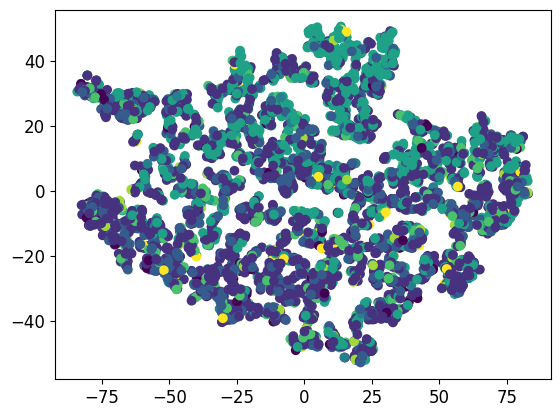

In [50]:
scatter=plt.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], c=le.transform(y))
plt.legend(handles=scatter.legend_elements()[0],labels=list(le.classes_),
                    bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Classes")